# Hamiltonian Monte Carlo for inverse problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The base sampler

In [167]:
def sample(target, initialModel, nt, dt, ns, mass_matrix):
    
    # Make sure the initial model is a column vector
    assert initialModel.shape == (initialModel.size, 1)

    # Create samples object. This is a lot faster than appending 
    # to a list, as all the memory is requested in one go. One 
    # Additional dimension is allocated for the misfits of every
    # model.
    samples = np.empty((initialModel.size + 1, ns))

    m = np.copy(initialModel)
    accepted = 0
    
    # Invert the mass matrix to accelerate computing. This might not always 
    # be possible for large laplacian-like mass matrices. In such cases
    # sparse solves in  every leapfrog iteration are preferred.
    inv_mass = np.linalg.inv(mass_matrix)
    
    # Start sampling
    for i_sample in range(ns):

        # Propose momentum
        p = np.random.multivariate_normal(np.zeros((m.size,)), mass_matrix, 1).T

        # Randomize integration parameters a little
        nt_local = int(np.random.uniform(low=0.5, high=1.5, size=None) * nt)
        dt_local = np.random.uniform(low=0.5, high=1.5, size=None) * dt

        # Compute the initial misfit, kinetic energy and Hamiltonian
        X = target.misfit(m)
        K = 0.5 * (p.T @ (np.linalg.inv(mass_matrix) @ p)).item()
        H = K + X

        # Create the new state as a copy
        m_new = np.copy(m)
        p_new = np.copy(p)

        # And start integrating the new state!
        p_new -= (dt_local / 2.0) * target.grad(m_new)
        for i in range(nt_local - 1):
            m_new += dt_local * inv_mass @ p_new
            p_new -= dt_local * target.grad(m_new)
        m_new += dt_local * inv_mass @ p_new
        p_new -= (dt_local / 2.0) * target.grad(m_new)

        # Compute the new misfit, kinetic energy and Hamiltonian
        X_new = target.misfit(m_new)
        K_new = 0.5 * (p_new.T @ inv_mass @ p_new).item()
        H_new = K_new + X_new

        # Accept if statistically relevant
        if np.exp(H - H_new) > np.random.uniform(low=0.0, high=1.0, size=None):
            m = np.copy(m_new)
            p = np.copy(p_new)
            # Reusing would allow us to skip the computation of X at the beginning 
            # of the loop, very useful for expensive problems. Additionally, we could 
            # save the last gradient to save even more computation time, which I do 
            # in my FWI work.
            X = X_new 
            accepted += 1

        # Add the new sample to the current sample. If the proposal was rejected,
        # we add the previous sample again.
        samples[:-1, i_sample] = m[:, 0]
        samples[-1, i_sample] = X

    print("%i accepted" % accepted)
    return samples

## Sampling a 5D multivariate normal

In [178]:
class target_mulitvariate_normal:
    def __init__(self, means=None, cov=None, dim=2):

        # Set mean
        if means is None:
            self.means = np.zeros((dim, 1))
        else:
            self.means = means

        # Set covariance
        if cov is None:
            self.cov = np.eye(dim)
            self.inv_cov = self.cov
        else:
            self.cov = cov
            self.inv_cov = np.linalg.inv(cov)

        # Make sure the dimensions are compatible
        assert self.cov.shape[0] == self.means.size

    def misfit(self, m):

        assert m.shape == self.means.shape

        dm = m - self.means

        return 0.5 * (dm.T @ (self.inv_cov @ dm)).item()

    def grad(self, m):

        assert m.shape == self.means.shape

        dm = m - self.means

        return self.inv_cov @ dm

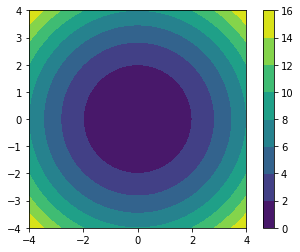

In [225]:
target = target_mulitvariate_normal(dim=5)

# A grid search over dimension 1 and 2
n1, n2 = 100, 100
dim1 = np.linspace(4, -4, n1)
dim2 = np.linspace(4, -4, n2)
m = np.zeros((5, 1))
dim1_v, dim2_v = np.meshgrid(dim1, dim2, sparse=False, indexing="ij")
misfit_v = np.empty_like(dim1_v)
for i in range(n1):
    for j in range(n2):
        m[0] = dim1_v[i,j]
        m[1] = dim2_v[i,j]
        misfit_v[i,j] = target.misfit(m)
plt.contourf(misfit_v, extent=[-4,4,-4,4])
plt.gca().axis('square')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.colorbar()

### Sampling with an appropriate mass matrix

In [190]:
m_init = np.zeros((5, 1)) + 1
mass_matrix = np.eye(5)
mass_matrix[1, 1] = 1
mass_matrix[0, 1] = 0.0
mass_matrix[1, 0] = 0.0

462 accepted


(array([[ 0.,  0.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  2.,  2.,  1.,  6.,  5.,  4.,  0.,  0.,  0.],
        [ 3.,  4.,  1.,  5.,  6., 13.,  7.,  1.,  0.,  0.],
        [ 4.,  4.,  9., 16., 14., 17.,  5.,  5.,  1.,  0.],
        [ 2.,  9., 14., 36., 32., 36., 16.,  7.,  1.,  0.],
        [ 0.,  7., 10., 11., 21., 19., 14.,  4.,  9.,  2.],
        [ 2.,  5., 10., 13., 16., 16., 10.,  2.,  1.,  2.],
        [ 0.,  0.,  1.,  5.,  5.,  5.,  4.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  1.,  1.,  2.,  5.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.]]),
 array([-3.0604509 , -2.41593167, -1.77141244, -1.12689321, -0.48237399,
         0.16214524,  0.80666447,  1.4511837 ,  2.09570293,  2.74022216,
         3.38474138]),
 array([-2.48452208, -1.94158381, -1.39864554, -0.85570727, -0.312769  ,
         0.23016927,  0.77310754,  1.31604581,  1.85898408,  2.40192235,
         2.94486062]),
 <matplotlib.collections.QuadMesh at 0x7fe1972ad6d8>)

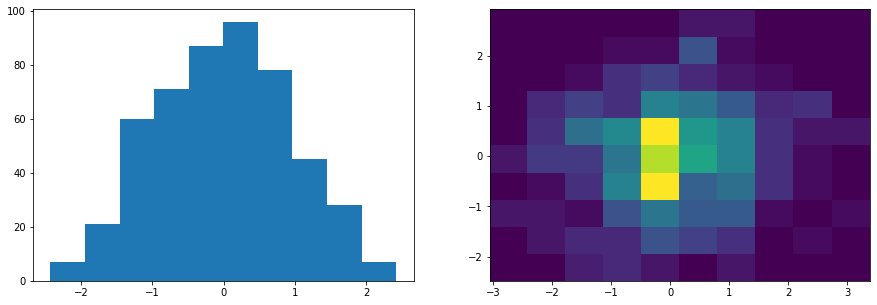

In [227]:
samples = sample(target, m_init, 10, 0.25, 500, mass_matrix)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(samples[3, :], bins=10)
plt.subplot(122)
plt.hist2d(samples[0, :], samples[1, :])

### Sampling with a operator mass matrix

One interesting aspect of Hamiltonian Monte Carlo is in a slow convergence setting. When within the duration of sampling convergence is not attained, the choice of mass matrix **heavily** influences the resulting samples.

What I do below is I use a mass matrix strongly correlated in dimension 1 and 2. I use this mass matrix in a Markov chain that has artificially slow convergence, *because I lowered the time step in HMC*. However, this is an analog for highly non-linear models, where we need a lot of small steps to conserve the Hamiltonian.

The result is that **initially**, the models with this high correlation are explored. Even though our target is the same as the previous chain, the result is very different! We obviously not converged yet. 

This is of course a bad thing when it is done unconsciously. But, in an environment where we'd like explore a specific type of model first, e.g. smooth models, this is actually very helpful. We don't need to restrict the Bayesian inverse problem to smooth models using a prior, excluding all other possibilities. We just explore the smooth models relatively earlier in the process. The only thing we'd have to do is encode this requirement into the mass matrix.

An interesting consequence of this is that for quadratic targets, if the mass matrix is similar to the posterior Hessian, convergence is achieved the fastest.

In [206]:
m_init = np.zeros((5, 1)) + 1
correlated_mass_matrix = np.eye(5)
correlated_mass_matrix[1, 1] = 1
correlated_mass_matrix[0, 1] = 0.95  # Look here!
correlated_mass_matrix[1, 0] = 0.95  # Look here!

500 accepted


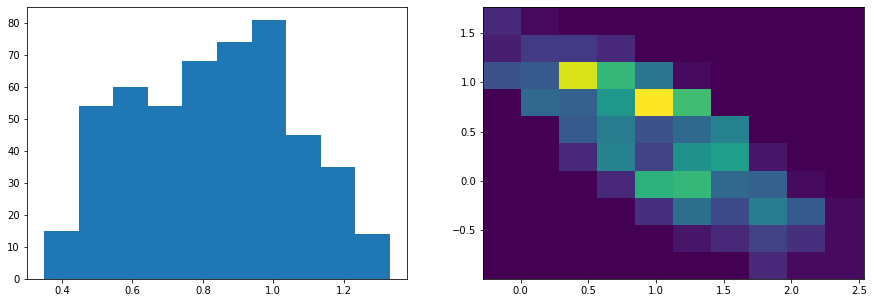

In [208]:
samples = sample(target, m_init, 10, 0.005, 500, correlated_mass_matrix)  # Important change in dt!!

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(samples[3, :], bins=10)
plt.subplot(122)
plt.hist2d(samples[0, :], samples[1, :]);

What a strong **false** correlation!

Of course, since we have not changed our target, in the limit of many samples, the result should be the same. And, if we do propose many samples, we end up with the same result:

50000 accepted


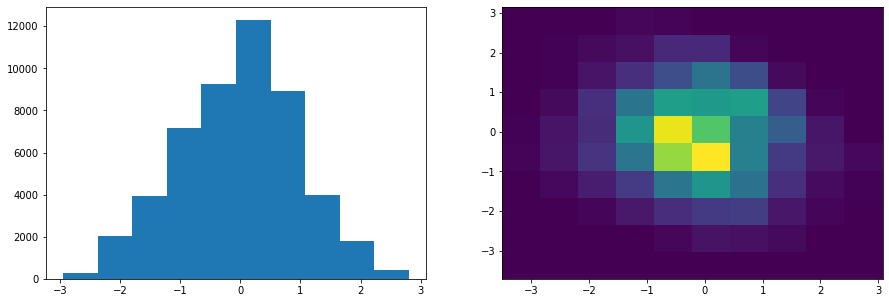

In [205]:
samples = sample(target, m_init, 10, 0.005, 50000, correlated_mass_matrix)  # Important change in dt and ns!!

plt.figure(figsize=(15, 5));
plt.subplot(121);
plt.hist(samples[3, :], bins=10);
plt.subplot(122);
plt.hist2d(samples[0, :], samples[1, :]);

# Animation

In [60]:
from IPython import display

In [97]:
def sample_animated(
    axis,
    dim1,
    dim2,
    targetFunction,
    grad,
    initialModel,
    nt,
    dt,
    ns,
    mass_matrix,
):

    # Make sure the initial model is a column vector
    assert initialModel.shape == (initialModel.size, 1)

    # Create sample object
    samples = np.empty((initialModel.size + 1, ns))

    m = initialModel

    print(ns)

    accepted = 0

    inv_mass = np.linalg.inv(mass_matrix)

    current_point = None
    lf_points = []

    for i_sample in range(ns):

        if current_point:
            current_point.set_visible(False)
            for point in lf_points:
                point.set_visible(False)
            lf_points = []

        plt.scatter(m[dim1], m[dim2], color="k", alpha=0.1)
        current_point = plt.scatter(m[dim1], m[dim2], color="r")

        display.clear_output(wait=True)

        display.display(plt.gcf())

        p = np.random.multivariate_normal(np.zeros((m.size,)), mass_matrix, 1).T
        
        nt_local = int(np.random.uniform(low=0.5, high=1.5, size=None) * nt)
        dt_local = np.random.uniform(low=0.5, high=1.5, size=None) * dt
        
        
        # Compute initial misfit, kinetic energy and Hamiltonian
        X = targetFunction(m)
        K = 0.5 * (p.T @ (np.linalg.inv(mass_matrix) @ p)).item()
        H = K + X

        m_new = np.copy(m)
        p_new = np.copy(p)

        arrow = plt.quiver(
                m_new[dim1],
                m_new[dim2],
                p_new[dim1],
                p_new[dim2],
                units="xy",
                minshaft=0,
                scale=5,
                minlength=0,
                headlength=5./4.,
                headaxislength=4.5/4.,
                headwidth=3./4.,
        )
        arrowGrad = plt.quiver(
                m_new[dim1],
                m_new[dim2],
                -grad(m_new)[dim1],
                -grad(m_new)[dim2],
                units="xy",
                minshaft=0,
                scale=5,
                minlength=0,
                headlength=5./4.,
                headaxislength=4.5/4.,
                headwidth=3./4.,
                color='red'
            )
        display.clear_output(wait=True)
        display.display(plt.gcf())

        p_new -= (dt_local / 2.0) * grad(m_new)

        for i in range(nt_local - 1):
            m_new += dt_local * inv_mass @ p_new

            arrow.set_visible(False)
            arrowGrad.set_visible(False)
            lf_points.append(
                plt.scatter(m_new[dim1], m_new[dim2], color="k", marker="x")
            )
            arrow = plt.quiver(
                m_new[dim1],
                m_new[dim2],
                p_new[dim1],
                p_new[dim2],
                units="xy",
                minshaft=0,
                scale=5,
                minlength=0,
                headlength=5./4.,
                headaxislength=4.5/4.,
                headwidth=3./4.,
            )
            arrowGrad = plt.quiver(
                m_new[dim1],
                m_new[dim2],
                -grad(m_new)[dim1],
                -grad(m_new)[dim2],
                units="xy",
                minshaft=0,
                scale=5,
                minlength=0,
                headlength=5./4.,
                headaxislength=4.5/4.,
                headwidth=3./4.,
                color='red'
            )
            display.clear_output(wait=True)
            display.display(plt.gcf())
            p_new -= dt_local * grad(m_new)

        m_new += dt_local * inv_mass @ p_new
        lf_points.append(plt.scatter(m_new[dim1], m_new[dim2], color="k", marker="x"))
        arrow.set_visible(False)
        arrowGrad.set_visible(False)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        p_new -= (dt_local / 2.0) * grad(m_new)

        X_new = targetFunction(m_new)
        K_new = 0.5 * (p_new.T @ inv_mass @ p_new).item()
        H_new = K_new + X_new

        if np.exp(H - H_new) > np.random.uniform(low=0.0, high=1.0, size=None):
            m = np.copy(m_new)
            p = np.copy(p_new)

            X = X_new
            accepted += 1

        samples[:-1, i_sample] = m[:, 0]
        samples[-1, i_sample] = X

    display.clear_output(wait=True)
    print("%i accepted" % accepted)
    return samples

KeyboardInterrupt: 

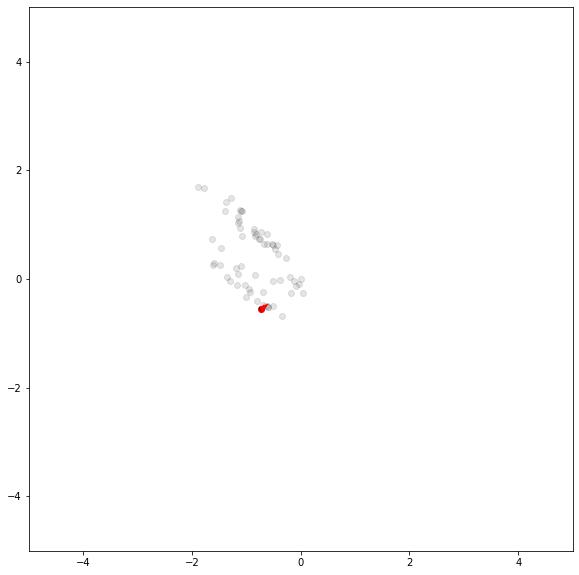

In [123]:
m_init = np.zeros((5, 1)) 

mass_matrix = np.eye(5) 
mass_matrix[1,1] = 1
mass_matrix[0,1] = 0.9
mass_matrix[1,0] = 0.9

fig = plt.figure(figsize=(10,10))
axis = plt.gca()
dim1 = 0
dim2 = 1

axis.set_xlim([-5,5])
axis.set_ylim([-5,5])
axis.set_aspect("equal")

samples = sample_animated(
    axis,
    dim1,
    dim2,
    misfit_mvn_target,
    grad_mvn_target,
    m_init,
    2,
    0.1,
    250,
    mass_matrix,
)